## Helpers

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

CLASS_MAPPING = {
    0: 'background', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant',
    12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog',
    18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra',
    24: 'giraffe', 25: 'backpack', 26: 'umbrella', 27: 'handbag', 28: 'tie',
    29: 'suitcase', 30: 'frisbee', 31: 'skis', 32: 'snowboard', 33: 'sports ball',
    34: 'kite', 35: 'baseball bat', 36: 'baseball glove', 37: 'skateboard',
    38: 'surfboard', 39: 'tennis racket', 40: 'bottle', 41: 'wine glass',
    42: 'cup', 43: 'fork', 44: 'knife', 45: 'spoon', 46: 'bowl', 47: 'banana',
    48: 'apple', 49: 'sandwich', 50: 'orange', 51: 'broccoli', 52: 'carrot',
    53: 'hot dog', 54: 'pizza', 55: 'donut', 56: 'cake', 57: 'chair',
    58: 'couch', 59: 'potted plant', 60: 'bed', 61: 'dining table',
    62: 'toilet', 63: 'tv', 64: 'laptop', 65: 'mouse', 66: 'remote',
    67: 'keyboard', 68: 'cell phone', 69: 'microwave', 70: 'oven',
    71: 'toaster', 72: 'sink', 73: 'refrigerator', 74: 'book',
    75: 'clock', 76: 'vase', 77: 'scissors', 78: 'teddy bear', 79: 'hair drier', 80: 'toothbrush'
}

COLOR_MAPPING = {
    'background': (84, 4, 174), 'person': (9, 103, 170), 'bicycle': (201, 111, 229),
    'car': (131, 248, 171), 'motorcycle': (185, 27, 137), 'airplane': (22, 228, 170),
    'bus': (202, 248, 15), 'train': (225, 100, 145), 'truck': (36, 79, 253),
    'boat': (140, 8, 2), 'traffic light': (201, 198, 90), 'fire hydrant': (159, 220, 2),
    'stop sign': (255, 19, 79), 'parking meter': (68, 82, 112), 'bench': (253, 171, 69),
    'bird': (89, 167, 80), 'cat': (196, 99, 53), 'dog': (192, 33, 156),
    'horse': (227, 207, 71), 'sheep': (159, 207, 242), 'cow': (29, 20, 24),
    'elephant': (223, 228, 107), 'bear': (143, 127, 190),
    'zebra': (46, 176, 231), 'giraffe': (109, 198, 31),
    'backpack': (191, 221, 194), 'umbrella': (189, 240, 16), 'handbag': (28, 211, 83),
    'tie': (48, 100, 27), 'suitcase': (120, 242, 50), 'frisbee': (25, 144, 63),
    'skis': (197, 70, 103), 'snowboard': (224, 243, 72), 'sports ball': (157, 226, 48),
    'kite': (38, 251, 212), 'baseball bat': (20, 227, 139), 'baseball glove': (181, 56, 56),
    'skateboard': (141, 120, 184), 'surfboard': (77, 61, 85), 'tennis racket': (33, 76, 183),
    'bottle': (149, 16, 141), 'wine glass': (83, 78, 117), 'cup': (128, 25, 196),
    'fork': (75, 170, 253), 'knife': (63, 169, 114), 'spoon': (179, 128, 36),
    'bowl': (7, 10, 172), 'banana': (231, 112, 175),
    'apple': (225, 227, 74), 'sandwich': (138, 128, 9), 'orange': (19, 130, 196),
    'broccoli': (169, 35, 116), 'carrot': (186, 146, 4), 'hot dog': (179, 248, 213),
    'pizza': (158, 132, 133), 'donut': (111, 57, 238), 'cake': (81, 39, 5),
    'chair': (67, 106, 138), 'couch': (166, 126, 162), 'potted plant': (6, 199, 214),
    'bed': (235, 15, 165), 'dining table': (229, 228, 125), 'toilet': (102, 40, 22),
    'tv': (125, 59, 103), 'laptop': (156, 43, 239), 'mouse': (81, 55, 193),
    'remote': (94, 49, 173), 'keyboard': (142, 88, 51), 'cell phone': (134, 145, 134),
    'microwave': (58, 170, 231), 'oven': (25, 115, 197), 'toaster': (175, 111, 7),
    'sink': (150, 3, 161), 'refrigerator': (131, 144, 255), 'book': (87, 153, 78),
    'clock': (97, 126, 55), 'vase': (37, 200, 9), 'scissors': (241, 136, 204), 'teddy bear': (181, 101, 239),
    'hair drier': (79, 213, 167), 'toothbrush': (248, 201, 178)
}

In [2]:
from dataclasses import dataclass
from typing import Tuple, List

from dataclasses_json import DataClassJsonMixin


@dataclass(frozen=True)
class BoundingBox(DataClassJsonMixin):
    left_top: Tuple[int, int]
    right_bottom: Tuple[int, int]


@dataclass
class DetectedObject(DataClassJsonMixin):
    bbox: BoundingBox
    confidence: float
    label: int
    class_name: str


@dataclass
class DetectedObjects(DataClassJsonMixin):
    detected_objects: List[DetectedObject]

## Client

Make sure gateway and object detection service works

In [3]:
import numpy as np
import requests

DIRECT_URL = "http://127.0.0.1:50001/maas_workshop/v2/object_detection/detect"
GATEWAY_URL = "http://127.0.0.1:50000/maas_workshop/v2/gateway/detect_objects"

def detect_people(image: np.ndarray) -> DetectedObjects:
    raw_image = image_to_jpeg_bytes(image=image)
    files = {'image': raw_image}
    response = requests.post(DIRECT_URL, files=files)
    if response.status_code == 200:
        return DetectedObjects.from_json(response.text)
    else:
        raise RuntimeError(
            f'Error code: {response.status_code}, Cause: {response.text}'
        )


def image_to_jpeg_bytes(
    image: np.ndarray,
    compression_rate: int = 90
) -> bytes:
    if compression_rate <= 0 or compression_rate > 100:
        raise ValueError("Compression rate must be in range (0; 100]")
    encode_param = [int(cv.IMWRITE_JPEG_QUALITY), compression_rate]
    _, raw_image = cv.imencode('.jpg', image, encode_param)
    return raw_image

## Visualisation

In [4]:
def visualise_inference_results(
    input_image: np.ndarray,
    inference_results: DetectedObjects
) -> np.ndarray:
    input_image = input_image.copy()
    for inference_result in inference_results.detected_objects:
        input_image = _draw_bbox(
            input_image=input_image,
            inference_result=inference_result
        )
    return input_image
    
    
def _draw_bbox(
    input_image: np.ndarray,
    inference_result: DetectedObject
) -> np.ndarray:
    color = COLOR_MAPPING[inference_result.class_name]
    cv.rectangle(
        img=input_image,
        pt1=inference_result.bbox.left_top,
        pt2=inference_result.bbox.right_bottom,
        color=color,
        thickness=5
    )
    return input_image

## Demo

In [5]:
from glob import glob

IMAGES_PATHS = glob("../data/object_detection/*")

In [6]:
IMAGE = cv.imread(IMAGES_PATHS[3])[:, :, ::-1]

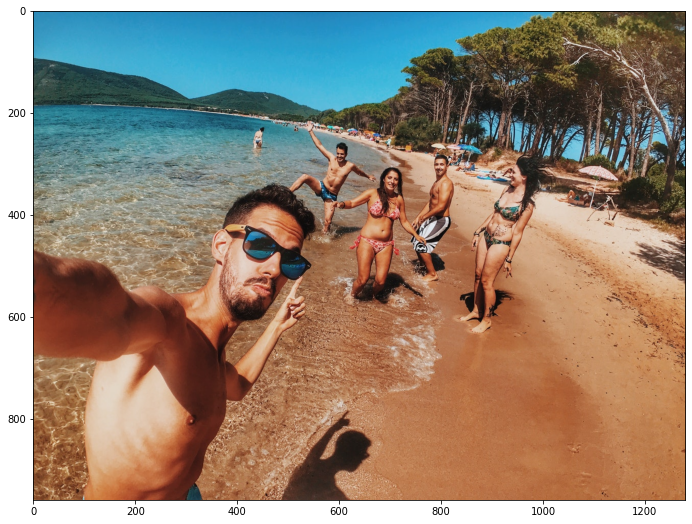

In [7]:
plt.imshow(IMAGE)

In [8]:
INFERENCE_RESULTS = detect_people(image=IMAGE)

In [9]:
INFERENCE_RESULTS

DetectedObjects(detected_objects=[DetectedObject(bbox=BoundingBox(left_top=(15, 340), right_bottom=(546, 953)), confidence=0.933907687664032, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(843, 285), right_bottom=(986, 624)), confidence=0.8427776098251343, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(587, 313), right_bottom=(768, 575)), confidence=0.8300632834434509, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(739, 278), right_bottom=(828, 538)), confidence=0.7176290154457092, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(432, 230), right_bottom=(453, 273)), confidence=0.6731247901916504, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(506, 231), right_bottom=(675, 442)), confidence=0.6640347838401794, label=1, class_name='person'), DetectedObject(bbox=BoundingBox(left_top=(512, 229), right_bottom=(518, 239)), confidence=0.5200677514076233, label=1, cla

In [10]:
VISUALISATION = visualise_inference_results(
    input_image=IMAGE,
    inference_results=INFERENCE_RESULTS
)

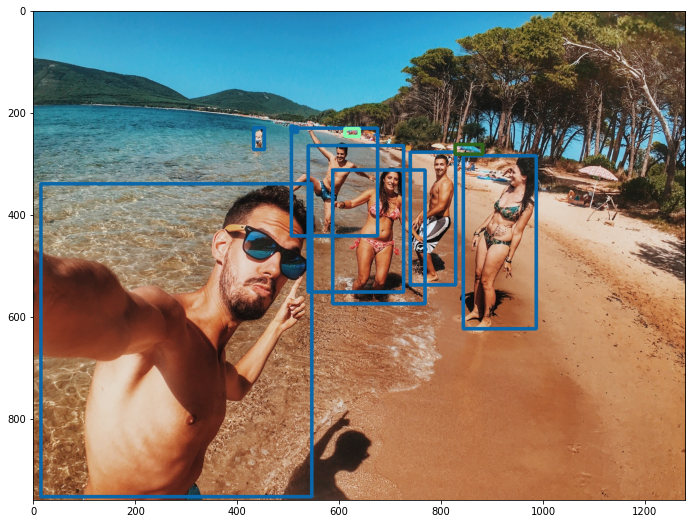

In [11]:
plt.imshow(VISUALISATION)